# Gender Pay Gap - A Myth Or A Reality?

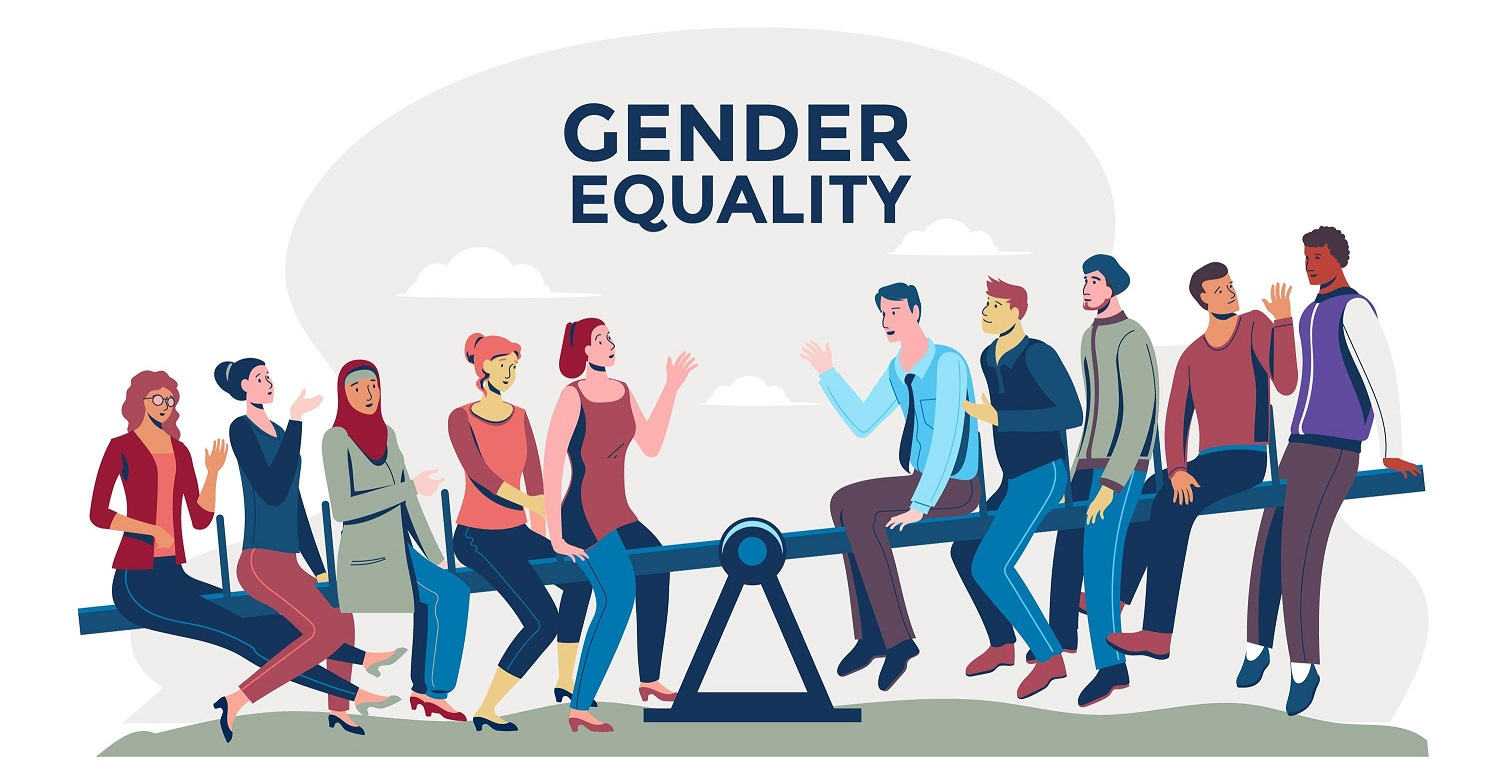
<center>Photo <a href="http://www.freepik.com">Designed by Freepik</a>.</center>

If you go to any tech company right now to meet their tech department, you're about to open the door, and I stop you for a second and ask you: There are 20 employees behind this door, can you take a guess as to how many of them are women? You'd probably say 4 to 6, right? or even lower numbers. 4-6 is actually not a bad guess given that women hold only [26%](https://techjury.net/blog/women-in-technology-statistics/#gref) of computing jobs, a figure that has been on the [decline](https://www.ncwit.org/sites/default/files/resources/womenintech_facts_fullreport_05132016.pdf) for the past several years. The reasons for such an outcome are diverse and complexe, going from education (with only [18%](https://www.ncwit.org/infographic/3435) of undergraduate computer science degrees being held by women) to the ["bro-culture"](https://www.breathehr.com/en-gb/blog/topic/company-culture/bro-culture-and-why-its-an-issue-for-startups) engraved in many tech companies.

However, setting aside the gender distribution in the tech field, are men and women really that different? More interestingly, are there any differences when it comes to salaries and compensations?

You've surely heard of the famous [for every dollar a man makes](https://www.businessinsider.com/gender-wage-pay-gap-charts-2017-3#major-cities-show-an-even-bigger-discrepancy-2) propaganda that has been going for several years now, but didn't really give it a second thought. In fact, and according to [Pew Research Center](https://www.pewsocialtrends.org/2018/01/09/women-in-stem-see-more-gender-disparities-at-work-especially-those-in-computer-jobs-majority-male-workplaces/), *\"Women in STEM see more gender disparities at work, especially those in computer jobs, majority-male workplaces\"*, and that for computing fields, women earn 87% of what men earn. So, do all these reports and numbers hold true in the data science and machine learning community on Kaggle? Buckle up your seatbelts and get ready to dive into a data-driven adventure, empowered by the [2020 Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/c/kaggle-survey-2020) dataset in the quest of asserting the validity or invalidity of a gender pay gap within our beloved community.

### **Table of Content:**

1. [Introduction: Who Answered The Survey?](#head-1)
2. [Men and Women: The Representation](#head-2)
3. [Men VS Women: A Deeper Dive Into The Pay Gap Theory](#head-3)
  
Appendix:
 * [Bonus: What Degree do I Need to Work as ... ?](#head-4)

### Data Cleaning and Pre-Processing

In [ ]:
# The following is a series of setup and data cleaning/pre-processing
!pip install pywaffle wordcloud

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image
from pywaffle import Waffle
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import math
import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv('/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

df.head()

In [ ]:
# Get total row count
df.shape[0]

In [ ]:
# Dropping the column descriptive row
df = df.drop(df.index[0])

# Adding a count column equal to 1 for all rows. This will be useful for later visualizations
df['count'] = 1

df.head()

In [ ]:
# Replacing some long strings with smaller representations
df.replace({"Iran, Islamic Republic of..." : "Iran",
            "United States of America" : "USA",
            "United Kingdom of Great Britain and Northern Ireland" : "UK",
            "Republic of Korea" : "Korea",
            "United Arab Emirates": "UAE",
            "No formal education past high school" : "High school",
            "Some college/university study without earning a bachelor’s degree" : "College/university without degree"},
           inplace=True)

In [ ]:
# Renaming single anwser questions
df.rename({'Time from Start to Finish (seconds)': 'Time to Complete',
           'Q1': 'Age Range',
           'Q2': 'Gender',
           'Q3': 'Country',
           'Q4': 'Education',
           'Q5': 'Role Title',
           'Q6': 'Years of Programming',
           'Q8': 'First Language Recommendation',
           'Q11': 'Computing Platform',
           'Q13': 'Times Used TPU',
           'Q15': 'Years of Machine Learning',
           'Q20': 'Company Size',
           'Q21': 'Data Science Employees',
           'Q22': 'Machine Learning Incorporation',
           'Q24': 'Compensation Range',
           'Q25': 'Money Spent on Machine Learning',
           'Q30': 'Big Data Product',
           'Q32': 'Business Intelligence Tool',
           'Q38': 'Tool to Analyze Data',
          },
          axis='columns', inplace=True)

In [ ]:
# Creating a new column, Salary, being an approximate continuous number of the yearly compensation provided in ranges
compensation = df['Compensation Range'].str.replace(r'(?:(?!\d|\-).)*', '').str.split('-')
df['Salary'] = compensation.apply(lambda x: (int(x[0]) + int(x[-1]))/ 2 if not isinstance(x, float) else x).astype(float)

# Creating a new column, Age, being an approximate continuous number of the age provided in ranges
age = df['Age Range'].str.replace(r'(?:(?!\d|\-).)*', '').str.split('-')
df['Age'] = age.apply(lambda x: (int(x[0]) + int(x[-1]))/ 2 if not isinstance(x, float) else x).astype(int)

In [ ]:
# Converting time to complete column to int
df = df.astype({"Time to Complete": int})

In [ ]:
# Removing all responses that took less than 30 seconds or more than 12 hours
df = df[ (30 <= df["Time to Complete"]) & (df["Time to Complete"] <= 12*60*60) ]

In [ ]:
# Checking the number of rows after these removals
df.shape[0]

In [ ]:
# Most answered questions
df.isna().sum().sort_values().head(20)

In [ ]:
def replace_multi_anwser_question(question_num, new_anwsers_list, use_prefix=True):
    if use_prefix:
        prefix = "Use "
    else:
        prefix = ""
    for i, anwser in enumerate(new_anwsers_list):
        if 'Other' in anwser:
            df.rename({f'Q{question_num}_OTHER': f'{prefix}{anwser}'}, axis='columns', inplace=True)
            df[f'{prefix}{anwser}'] = (df[f'{prefix}{anwser}'].notnull()).astype('int')
            print(f"Replaced Q{question_num}_OTHER with '{prefix}{anwser}' int column!")
        else:
            df.rename({f'Q{question_num}_Part_{i+1}': f'{prefix}{anwser}'}, axis='columns', inplace=True)
            df[f'{prefix}{anwser}'] = (df[f'{prefix}{anwser}'].notnull()).astype('int')
            print(f"Replaced Q{question_num}_Part_{i+1} with '{prefix}{anwser}' int column!")

In [ ]:
languages = ['Python', 'R', 'SQL', 'C', 'C++', 'Java', 'Javascript', 'Julia', 'Swift',
             'Bash', 'MATLAB', 'None Language', 'Other Language']
replace_multi_anwser_question('7', languages)

In [ ]:
viz_libs = ['Matplotlib', 'Seaborn', 'Plotly / Plotly Express', 'Ggplot / ggplot2', 'Shiny',
            'D3 js', 'Altair', 'Bokeh', 'Geoplotlib', 'Leaflet / Folium',
            'None Viz Library', 'Other Viz Library']
replace_multi_anwser_question('14', viz_libs)

In [ ]:
ML_frameworks = ['Scikit-learn', 'TensorFlow', 'Keras', 'PyTorch', 'Fast.ai', 'MXNet', 'Xgboost',
                 'LightGBM', 'CatBoost', 'Prophet', 'H2O 3', 'Caret', 'Tidymodels', 'JAX',
                 'None ML Framework', 'Other ML Framework']
replace_multi_anwser_question('16', ML_frameworks)

In [ ]:
big_data_products = ['MySQL', 'PostgreSQL', 'SQLite', 'Oracle Database', 'MongoDB', 'Snowflake',
                     'IBM Db2', 'Microsoft SQL Server', 'Microsoft Access', 'Microsoft Azure Data Lake Storage',
                     'Amazon Redshift', 'Amazon Athena', 'Amazon DynamoDB', 'Google Cloud BigQuery', 'Google Cloud SQL',
                     'Google Cloud Firestore', 'None Big Data Products', 'Other Big Data Products']
replace_multi_anwser_question('29_A', ML_frameworks)

In [ ]:
BI_products = ['Amazon QuickSight', 'Microsoft Power BI', 'Google Data Studio', 'Looker',
               'Tableau', 'Salesforce', 'Einstein Analytics', 'Qlik', 'Domo', 'TIBCO Spotfire',
               'Alteryx', 'Sisense', 'SAP Analytics Cloud', 'None BI Products', 'Other BI Products']
replace_multi_anwser_question('31_A', BI_products)

In [ ]:
sharing_platforms = ['Plotly Dash', 'Streamlit', 'NBViewer', 'GitHub', 'Personal blog',
                     'Kaggle', 'Colab', 'Shiny', 'None Sharing Platforms', 'Other Sharing Platforms']
replace_multi_anwser_question('36', sharing_platforms)

In [ ]:
courses_platforms = ['Coursera', 'edX', 'Kaggle Learn Courses', 'DataCamp', 'Fast.ai', 'Udacity',
                     'Udemy', 'LinkedIn Learning', 'Cloud-certification programs (direct from AWS, Azure, GCP, or similar)',
                     'University Courses (resulting in a university degree)', 'None Courses Platforms', 'Other Courses Platforms']
replace_multi_anwser_question('37', courses_platforms)

In [ ]:
favorite_medias = ['Twitter (data science influencers)', 'Email newsletters (Data Elixir, O\'Reilly Data & AI, etc)',
                   'Reddit (r/machinelearning, etc)', 'Kaggle (notebooks, forums, etc)',
                   'Course Forums (forums.fast.ai, Coursera forums, etc)',
                   'YouTube (Kaggle YouTube, Cloud AI Adventures, etc)',
                   'Podcasts (Chai Time Data Science, O’Reilly Data Show, etc)',
                   'Blogs (Towards Data Science, Analytics Vidhya, etc)',
                   'Journal Publications (peer-reviewed journals, conference proceedings, etc)',
                   'Slack Communities (ods.ai, kagglenoobs, etc)', 'None Favorite Medias', 'Other Favorite Medias']
replace_multi_anwser_question('39', favorite_medias)

In [ ]:
tasks_at_work = ['Analyze and understand data to influence product or business decisions',
                 'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
                 'Build prototypes to explore applying machine learning to new areas',
                 'Build and/or run a machine learning service that operationally improves my product or workflows',
                 'Experimentation and iteration to improve existing ML models',
                 'Do research that advances the state of the art of machine learning',
                 'None of these activities are an important part of my role at work',
                 'Other tasks at work']
replace_multi_anwser_question('23', tasks_at_work, use_prefix=False)

In [ ]:
# Converting several columns to categorical with order
education_level_order = ['High school', 'College/university without degree', 'Professional degree',
                         'Bachelor’s degree', 'Master’s degree', 'Doctoral degree']
cat_dtype = pd.api.types.CategoricalDtype(categories=education_level_order, ordered=True)
df.Education = df.Education.astype(cat_dtype)

In [ ]:
years_programming_order = ['I have never written code', '< 1 years', '1-2 years',
                         '3-5 years', '5-10 years', '10-20 years', '20+ years']
cat_dtype = pd.api.types.CategoricalDtype(categories=years_programming_order, ordered=True)
df['Years of Programming'] = df['Years of Programming'].astype(cat_dtype)

In [ ]:
age_range_order = ['18-21', '22-24', '25-29','30-34','35-39', '40-44', '45-49', '50-54','55-59','60-69', '70+']
cat_dtype = pd.api.types.CategoricalDtype(categories=age_range_order, ordered=True)
df['Age Range'] = df['Age Range'].astype(cat_dtype)

In [ ]:
years_machine_learning_order = ['I do not use machine learning methods', 'Under 1 year', '1-2 years','2-3 years',
                                '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years']
cat_dtype = pd.api.types.CategoricalDtype(categories=years_machine_learning_order, ordered=True)
df['Years of Machine Learning'] = df['Years of Machine Learning'].astype(cat_dtype)

In [ ]:
company_size_order = ['0-49 employees', '50-249 employees', '250-999 employees', '1000-9,999 employees', '10,000 or more employees']
cat_dtype = pd.api.types.CategoricalDtype(categories=company_size_order, ordered=True)
df['Company Size'] = df['Company Size'].astype(cat_dtype)

In [ ]:
data_science_employees_order = ['0', '1-2', '3-4', '5-9', '10-14', '15-19', '20+']
cat_dtype = pd.api.types.CategoricalDtype(categories=data_science_employees_order, ordered=True)
df['Data Science Employees'] = df['Data Science Employees'].astype(cat_dtype)

In [ ]:
df

# 1. Introduction: Who Answered The Survey? <a class="anchor" id="head-1"></a>

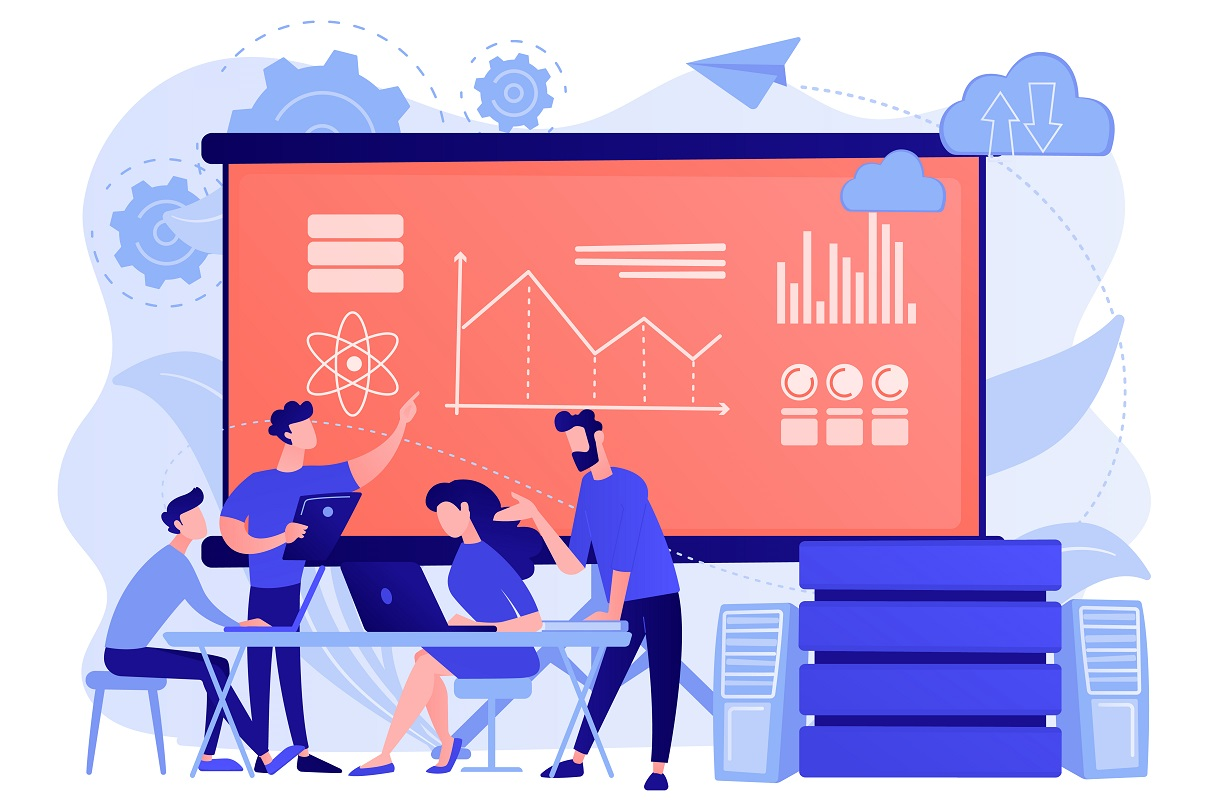
<center>Photo <a href="http://www.freepik.com">Designed by Freepik</a>.</center>

Before jumping into the core questions of this adventure, let's take a moment to understand the distribution of the data we will be working with. Understanding the distribution of the participants in this survey will prove to be very beneficial when working our heads around various results later in the notebook.

So, let's answer the following questions:
* What's the age distribution of the survey participants?
* What's the gender distribution of the survey participants?
* What role titles do the participants hold?
* Where are the participants from?
* What's the profile of a model Kaggle user?

---

**⚠ WARNING:** Keep in mind while going through this notebook that 19K+ kagglers responded to this survey. Despite it looking like a big number, no "certain" conclusion can be inferred from this data. That being said, this study will serve as a preliminary exploration of possible inferences that could be further studied on larger scale samples in order for them to be statistically more powerful and therefore asserted.

---

In [ ]:
fig = px.bar(x=df.groupby('Age Range').size().index, y=df.groupby('Age Range').size().values,
             title="<b>Age Distribution of the Survey Respondents</b>",)
fig.update_layout(showlegend=False,
                  title_font_size=20,
                  yaxis={'title': "Number of Respondents",
                         "showgrid":False, "zeroline":False,
                         "fixedrange": True},
                  xaxis={"title":"Age Range",
                         "fixedrange": True},
                  plot_bgcolor='#fff')
fig.update_traces(hovertemplate = "Age Range: %{x}<br>Respondents: %{y}")
fig.add_shape(go.layout.Shape(type="rect", xref="paper", yref="paper",
                              x0=0.002, x1=3/11 - 0.001, y0=0, y1=1,
                              fillcolor="green", opacity=0.5, layer="below",
                              line={"width":3, "color":"DarkGreen"}))
fig.add_annotation(
    x=3/11, y=0.95,
    ax=200, ay=10,
    xref="paper", yref="paper", axref="x", ayref="y",
    text=f"<b>{sum(df.groupby('Age Range').size().values[:3]) / sum(df.groupby('Age Range').size().values) * 100:0.2f}%</b> of all respondents<br> are aged <b>18-29</b>",
    showarrow=True,
    font={
        "family":"Courier New, monospace",
        "size":16,
        "color":"#ffffff"
        },
    align="center",
    arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
    bordercolor="#c7c7c7", borderwidth=2, borderpad=4,
    bgcolor="#ff7f0e", opacity=0.7
    )
fig.show()

Starting off with the age distribution of the survey participants, we can observe a steady increase in the number of participants going up in age from 18 to 29, reaching its maximum value of *3871* respondents for the age group **25-29**. This is followed by a consistently downwards trend for older ages, reaching a low of *74* respondents aged **70+**.

It is clear that the survey participants profiles were dominated by younger people, in fact, **56%** of participants are aged between **18 and 29**. Those are people that are generally getting into university (18-21), finishing up their bachelors/masters (22-24) and starting off their careers with their first jobs (25-29).

Given that Kaggle is [10 years of age](https://en.wikipedia.org/wiki/Kaggle#:~:text=Kaggle%20got%20its%20start%20in,Anthony%20Goldbloom%20and%20Jeremy%20Howard.), seeing such a marginal dominance of younger people really holds high hopes for the future of the platform!

In [ ]:
gender_size = df.groupby('Gender').size().sort_values(ascending=False)

fig = px.bar(x=gender_size.index, y=gender_size.values,
             color=gender_size.index,
             title="<b>Gender Distribution of the Survey Respondents</b>",
             text=[str(x*100)[:str(x*100).find(".") + 3] + "%" for x in gender_size.apply(lambda x: x / gender_size.sum()).values]
            )
fig.update_traces(hovertemplate = "<b>%{x}</b><br>Respondents: %{y}<extra></extra>")
fig.update_layout(showlegend=False,
                  title_font_size=20,
                  yaxis={'title': "Number of Respondents", "gridcolor": "rgb(235,235,235)",
                         "zeroline":True, "zerolinecolor":"lightgrey"},
                  xaxis={"title":"Gender"},
                  plot_bgcolor='#fff'
                 )

fig.show()

As expected, the number of men responding to the survey greatly outweighs the number of women. Nearly *80%* of respondents are males, whereas around *20%* of them are females.
This reflects the **gender imbalance** in the data science and machine learning community, derived from the tech industry as a whole.

In [ ]:
role_title_size = df.groupby('Role Title').size().sort_values(ascending=False)

fig = px.bar(x=role_title_size.index, y=role_title_size.values,
             color=role_title_size.values,
             color_continuous_scale=px.colors.sequential.Blues,
             title="<b>Role Title Distribution of the Survey Respondents</b>",
             text=[str(x*100)[:str(x*100).find(".") + 2] + "%" for x in role_title_size.apply(lambda x: x / role_title_size.sum()).values]
            )
fig.update_traces(hovertemplate = "<b>%{x}</b><br>Respondents: %{y}")
fig.update_layout(showlegend=False,
                  title_font_size=20,
                  yaxis={"title": "Number of Respondents", "gridcolor": "rgb(235,235,235)",
                         "zeroline":True, "zerolinecolor":"lightgrey"},
                  xaxis={"title":"Role Title"},
                  plot_bgcolor="#fff",
                  coloraxis={"showscale":False}
                 )

fig.show()

Given the previously visualized age distribution showing a high number of respondents aged between 18 and 24, it's not surprising to see that *more than one quarter* of the survey respondents are **students**! Following this mode class, *1/8th* of the respondents are **data scientists** and *1/10th* are **software engineers**. The rarest job titles among the survey respondents were **data engineers**, **statisticians** and **DBA/database engineers**, representing *2.2%*, *1.5%* and *0.6%* of the survey respondents respectively.

It is also interesting to notice the 8.6% participation of currently not employed kagglers, who are probably trying to harness this platform's potential in order to increase their chances of landing a data job!

In [ ]:
countries = df.groupby('Country').size()
countries = countries.to_frame()
countries.columns = ['Respondents']
countries.index.names = ['Country']
countries.reset_index(level=0, inplace=True)
countries['log(Respondents)'] = np.log(countries['Respondents'])

fig = px.choropleth(countries,
                    locations="Country",
                    color="log(Respondents)",
                    locationmode = 'country names',
                    hover_data=['Respondents'],
                    color_continuous_scale='ylgn',
                    title = '<b>Country Distribution of the Survey Respondents</b>',
                    #hovertemplate="%{Country}"
                   )

scale_vals = [50, 100, 200, 400, 800, 1600, 3200]

fig.update_layout(title_font_size=20,
                  margin={"r":20, "l":30},
                  coloraxis={#"showscale":False,
                            "colorbar":dict(title="Number of Respondents",
                                            #range=[np.log(50), np.log(6400)],
                                            titleside="top",
                                            tickmode="array",
                                            tickvals=np.log(scale_vals),
                                            ticktext=scale_vals,
                                            ticks="outside"
                                        )}
                 )

fig.show()

It is absolutely amazing to see such a big diversity when it comes to the countries in which the participants of this survey responded from! In fact, in the map above we are seeing **55 countries** light up! Everyone of those countries is home to at least 50 respondents of the survey, as this is the condition for a given country to be listed in the dataset!

On the other hand, we had lots of people participating in the survey from other countries that did not meet the 50 respondents criteria to be listed. These participants were grouped in a category called "Other". In fact **1332** participants are listed in the "other" category!

Let's say in average, there were 25 participants from these anonymous countries, this would make up a total of 55 (the countries visualized above) + 53 (1332/25) ≈ 108 countries!!

This makes up for an astonishing country participation in this survey!

In [ ]:
!wget https://cdn4.iconfinder.com/data/icons/small-n-flat/24/globe-512.png

In [ ]:
d = dict(((k, v) for k, v in zip(countries[countries.Country != "Other"].Country, countries[countries.Country != "Other"].Respondents)))

globe_mask = np.array(Image.open("globe-512.png"))
globe_mask[globe_mask == 0] = 255

image_colors = ImageColorGenerator(globe_mask)

wc_globe = WordCloud(prefer_horizontal=0.75,
                     background_color="white", 
                     mode="RGBA",
                     mask=globe_mask)

wc_globe.generate_from_frequencies(d)

wc_globe.recolor(color_func = image_colors)



globe_img = Image.fromarray(wc_globe.to_array())
globe_mask_img = Image.fromarray(globe_mask)
new_img = Image.blend(globe_img, 
                      globe_mask_img, 
                      0.3)

plt.figure(figsize=(10,10))
plt.imshow(new_img, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
trace = go.Pie(labels=countries.Country,
               values=countries.Respondents, 
               title="<b>Country Distribution</b>",
               title_font_size=16,
               hovertemplate="<b>%{label}</b><br>Respondents: %{value}<br><i>%{percent}</i>",
               #hoverinfo='percent+value+label', 
               textinfo='percent',
               textposition='inside',
               hole=0.6,
               showlegend=True,
               marker=dict(colors=plt.cm.viridis_r(np.linspace(0, 1, 28)),
                           line=dict(color='#000000',
                                     width=2),
                          ),
               name=""
              )
fig=go.Figure(data=[trace])
fig.update_layout(legend={"title":"<b>Country</b><br>"})
fig.show()

Indian Kagglers leads the board here, with almost *one third* of respondents being from **India** ! That is *5704* Kagglers!

In the 2nd place, we have the **USA** with *2162* respondents making up *11.2%* of the respondents.

After these two dominating countries, other countries' representation falls off on a smooth curve going from *671* respondents from **Brazil** all the way to *51* respondents from **Ghana**.

In [ ]:
education_size = df.groupby('Education').size()#.sort_values(ascending=False)

fig = px.bar(x=education_size.index, y=education_size.values,
             color=education_size.index,
             color_discrete_sequence=px.colors.qualitative.Set3,
             title="<b>Education Distribution of the Survey Respondents</b>",
             text=[str(x*100)[:str(x*100).find(".") + 2] + "%" for x in education_size.apply(lambda x: x / education_size.sum()).values]
            )
fig.update_traces(hovertemplate = "<b>%{x}</b><br>Respondents: %{y}<extra></extra>")
fig.update_layout(showlegend=False,
                  title_font_size=20,
                  yaxis={"title": "Number of Respondents",
                         "zeroline":False, "showgrid":False,
                         "fixedrange": True},
                  xaxis={"title":"Highest Level of Formal Education",
                         "tickmode":"array", "tickvals": [0,1,2,3,4,5],
                         "ticktext":["High school", "College/university<br>without degree", "Professional degree",
                                     "Bachelor’s degree", "Master’s degree", "Doctoral degree"],
                         "fixedrange": True},
                  plot_bgcolor="#fff",
                  margin={"r":20, "l":30},
                 )

fig.add_shape(go.layout.Shape(type="rect", xref="paper", yref="paper",
                              x0=3/6, x1=5/6, y0=0, y1=1,
                              fillcolor="green", opacity=0.5, layer="below",
                              line={"width":3, "color":"DarkGreen"}))
fig.add_annotation(
    x=3/6, y=0.95,
    ax=-170, ay=20,
    xref="paper", yref="paper", axref="x", ayref="y",
    text=f"<b>{sum(df.groupby('Education').size().values[3:5]) / sum(df.groupby('Education').size().values) * 100:0.2f}%</b> of all respondents<br>hold a <b>Bachelor's</b> or<br><b>Master's</b> degree",
    showarrow=True,
    font={
        "family":"Courier New, monospace",
        "size":16,
        "color":"#ffffff"
        },
    align="center",
    arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
    bordercolor="#c7c7c7", borderwidth=2, borderpad=4,
    bgcolor="#ff7f0e", opacity=0.7
    )

fig.show()

Participation from **high school students** is very minimal with *1.2%*. This goes to reflect the novelty of this field and its unmature integration in high schools.

*3.6%* of respondents hold **professional degrees** whereas *5.6%* **don't hold any**. This ~10% of the population most probably are self-taught data scientists with reliance on online content and courses.

A staggering figure however is that *more than three quarters* of respondents hold, or plan to hold within 2 years, a **Bachelor's or Master's degree**! This means that the majority of data scientists chose the university pathway in order to forge their skills in this field, and consequently work in it.

Finally, *12%* of the respondents took the extra mile to complete a PhD program earning a **Doctoral degree**.

## Model Kaggler

In [ ]:
model_kaggler = df.groupby(['Age Range', 'Gender', 'Role Title', 'Education']).size().sort_values(ascending=False).head(20)

headerColor = 'royalblue'
rowEvenColor = 'lavender'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  columnwidth = [0.5,1,1.25,1.75,2,2],
  header=dict(
    values=["<b>Rank</b>"] + ["<b>" + x + "</b>" for x in model_kaggler.index.names] + ["<b>Respondents Count</b>"],
    line_color='darkslategray',
    fill_color=headerColor,
    align='center',
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=np.array([np.array(("<i>" + str(i+1) + "</i>",) + x + ("<b>" + str(y) + "</b>", )) for i, (x, y) in enumerate(zip(model_kaggler.index, model_kaggler.values))]).T,
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor]*10],
    align = 'center',
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.update_layout(
    title={"text": "<b>Top 20 Model Kagglers</b>",
           "x": 0.5,
           "xanchor":"center",
           "font_size": 22},
    margin={"r":20, "l":20})

fig.show()

Combining together all of the previously explored respondents characteristics, let's build up a list of the top 20 model kagglers! In other words, what is the profile of a typical kaggler?

By far the most typical kaggler profile is **a young man, aged 18-21, who's still a student and planning to hold a Bachelor's degree within 2 years**. *1303*, or *~7%* of respondents share this profile! Following up is the exact same profile a couple of years later, **having 22-24 years old and pursuing a Master's degree**.

The first appearance of women replicates the first appearance of men in the table. That is in the *4th* place, with *396* **young women, aged 18-21, and studying to earn a Bachelor's degree within 2 years**.

The first occurence of non-students in the table is at position *5* and *7*, with **male data scientists holding a Master's degree, that are 25-29 and 30-34 years of age respectively**. 

Also, note that I excluded from this table the Country, as all rows will be populated with Indian Kagglers, due to their extremely high participation rate in the survey!

-------------------------------------------------------------

Despite a much smaller representation, and with only 2 occurrences in the above table, women seem to follow a similar distribution to men given that these 2 occurrences are identical to the first 2 occurrences of men in the table. Is this similar distribution consistent throughout all the other features? Let's find out!

# 2. Men and Women: The Representation <a class="anchor" id="head-2"></a>

In [ ]:
df_men = df[df.Gender == "Man"]
df_women = df[df.Gender == "Woman"]
df_men_women = pd.concat([df_men, df_women])

In [ ]:
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '111': {
            'values': [df_men.shape[0] // 100, df_women.shape[0] // 100],
            'labels': ["{1} {0}".format(n[2], n[1]) for n in [[0, df_men.shape[0], 'Men'], [0, df_women.shape[0], 'Women']]],
            'legend': {'loc': 'lower left', 'bbox_to_anchor': (0.3, -0.18, 0.6, -0.18), 'fontsize': 18,
                       "ncol":2, "borderaxespad":0.},
            #'title': {'label': '# Hangouts Type', 'loc': 'center', 'fontsize':20},
            'icons': ['male', 'female'], # child, heart, user-friends, male, female, user, user-ninja
            'font_size' : 35,
        },
    },
    rows=8,
    colors=['#439CEF', '#FE62A6'], #3E88EF
    figsize=(14, 8),
    dpi = 240,
)

*~80%* of respondents are men, meaning **1 in 5 respondents is a women**!

---

Now that we have a general understanding of the participants in this survey, let's look into the various distributions of men and women along various features in this data. Will they share similar distributions despite an imbalanced distribution?

Do men and women have the same age distribution? Do they work similar jobs? Do they come from the same countries? Let's answer all of these questions and more below!

In [ ]:
countries_gender = df.groupby(['Country', 'Gender']).size()
countries_gender = countries_gender.to_frame()
countries_gender.columns = ['Respondents']
countries_gender.reset_index(level=0, inplace=True)
countries_gender.reset_index(level=0, inplace=True)
countries_gender = countries_gender[countries_gender.Gender != 'Prefer not to say']
countries_gender = countries_gender[countries_gender.Gender != 'Prefer to self-describe']
countries_gender = countries_gender[countries_gender.Gender != 'Nonbinary']

In [ ]:
# Bar chart with color breakdown in each bar

fig = px.bar(countries_gender, x="Country", y="Respondents", color='Gender',
            title="<b>Respondents Gender Breakdown by Country</b>")

fig.update_layout(
    title_font_size=20,
    xaxis={'categoryorder':'total descending'},
    yaxis={"gridcolor": "rgb(235,235,235)", "zeroline":True, "zerolinecolor":"lightgrey"},
    plot_bgcolor="#fff"
)

fig.show()

In the search of the country distribution of each gender, it is to be expected that a higher number of women participated in the survey from countries than had an overall bigger participation in the survey. For instance, *1253*, or *33.5%* of women respondents are from **India** and *465*, or *12.5%* of women respondents are from the **USA**.

However, instead of absolute total numbers, what would be more interesting is the **distribution** of women and men by country. That is, which country has the highest percentage of women participation and which country has the highest percentage of men participation. For that, let's move to the next graph!

In [ ]:
sum_per_country = countries_gender.groupby('Country').sum()
countries_gender['% of Respondents'] = countries_gender.apply(lambda row: row.Respondents / sum_per_country.at[row.Country, "Respondents"], axis = 1)
countries_woman = countries_gender[countries_gender.Gender == "Woman"]
sorted_countries_by_woman_percentage = countries_woman.sort_values("% of Respondents", ascending=False).Country.to_list()

In [ ]:
# Bar chart with color breakdown in each bar

fig = px.bar(countries_gender, x="Country", y="% of Respondents", color='Gender', hover_data=['Respondents'],
            title="<b>Respondents Gender Distribution by Country</b>")

fig.update_layout(title_font_size=20,
                  xaxis={"categoryorder":"array", "categoryarray":sorted_countries_by_woman_percentage},
                  yaxis={"tickformat":".1%", "range":[0,1]},
                  plot_bgcolor="#fff"
)
fig.add_annotation(x=0, y=1 - countries_woman['% of Respondents'].mean(), xref="paper",
                   text=f"Global Average = {str((countries_woman['% of Respondents'].mean()) * 100)[:4]}%",
                   showarrow=False,
                   xanchor="left",
                   yanchor="bottom",
                   bgcolor="#ffffff",
                   opacity=0.9,
                   font={"color":"Green", "size":14}
                  )
fig.add_shape(type='line',
              x0=-0.5, y0=1 - countries_woman['% of Respondents'].mean(),
              x1=countries_woman.shape[0] - 0.5, y1=1 - countries_woman['% of Respondents'].mean(),
              line={"color":'white', "width":5},
              opacity=0.9,
              xref='x', yref='y'
             )

fig.add_shape(type='line',
              x0=-0.5, y0=1 - countries_woman['% of Respondents'].mean(),
              x1=countries_woman.shape[0] - 0.5, y1=1 - countries_woman['% of Respondents'].mean(),
              line={"color":'Green', "width":3},
              xref='x', yref='y'
             )
fig.show()

With a global average of **19.4%** women participation throughout all countries, let's take a look at countries from both sides of the balance.

**Malaysia** leads the bunch here with a record *40%* women participation in the survey! It is closely followed by **Iran** and **Tunisia** with *36.3%* and *35.5%* women participation respectively.

The **UK**, the **UAE** and **South Africa** hit the exact average women participation.

On the other side of the spectrum, **Chile**, **Korea** and **Japan** secure the bottom 3 scores for women participation, scoring *8.6%*, *7.1%* and *6.8%* respectively.

It is also worth noting that not a single country had more women participate than men. Thus, this gender imbalance seems to be unanimously global, and not regional.

---

Moving forward, let's study each gender's distribution over various features, starting off with the age range distribution!

In [ ]:
def plot_gender_distribution(by, sort_by_mean=True, legend_x=0.99, legend_orientation="h"):
    role_gender = pd.concat([df_men.groupby(by).size().rename("Men"),
                             df_women.groupby(by).size().rename("Women")],
                            axis=1)
    role_gender = role_gender.iloc[:, :].apply(lambda x: x / x.sum())
    
    if sort_by_mean:
        xaxis_dict = {"categoryorder":"array", "categoryarray": list((df_women.groupby(by).size() + df_men.groupby(by).size()).sort_values(ascending=False).index)}
    else:
        xaxis_dict = {}
    
    fig = px.bar(role_gender, barmode="group",
                title=f"<b>Distribution of Each Gender by {by}</b>")
    fig.update_traces(hovertemplate = "<b>%{fullData.name}</b><br>" + by + ": %{x}<br>% Respondents: %{y}<extra></extra>")
    fig.update_layout(title_font_size=20,
                      yaxis={"title":"% of Respondents", "tickformat":".1%", "gridcolor": "rgb(235,235,235)",
                             "zeroline":True, "zerolinecolor":"lightgrey"},
                      xaxis = xaxis_dict,
                      legend={"yanchor":"top", "y":0.97, "xanchor":"right", "x":legend_x, "title":"", "orientation":legend_orientation},
                      plot_bgcolor="#fff")
    fig.update_traces(marker_line_color='rgb(55,55,55)',
                      marker_line_width=1.5, opacity=0.9)
    fig.show()

In [ ]:
plot_gender_distribution(by="Age Range", sort_by_mean=False)

We can observe above a graph that plots the distribution of each gender by age group. This means that each bar in the graph represents a chunk, or a percentage, of its overall gender class (i.e, not from the overall population nor from the x axis population). For instance, the first 2 bars on the chart can be interpreted as follows: *16.6% of men are aged 18-21* and *20.7% of women are aged 18-21*. Keep this in mind while going through the rest of the graphs on this section!
 
Analyzing this graph, we can notice that the women's distribution is more skewed towards the right (younger ages), in contrast with the men's distribution that is more evenly distributed over older ages.

The men's demographic reflects their longer participation and involvement in the field throughout the past decades. Nevertheless, the women's demographic promises high hopes for a more gender-balanced future in the field of data science, as more and more young women are getting encouraged to partake in this amazing field!

In [ ]:
plot_gender_distribution(by="Role Title")

Now, plotting the distribution of each gender by their role title, we can clearly observe the effect of the previous visualization here! Having a younger overall profile, **one third** of women are students, in contrast to only **one quarter** of men being students.

**Software Engineer**, **Machine Learning Engineer** and **Product/Project Manager** seem to be roles more appealing to men.

Whereas **Data Analyst**, **Research Scientist** and **Statistician** seems to be more popular options for women.

In [ ]:
plot_gender_distribution(by="Years of Programming", sort_by_mean=False)

The age distribution shows its mark once again here, with a more left-skewed distribution for women when it comes to the participants' programming experience. Meaning that women tend to have less programming experience than men do.

Most respondents seem to have anywhere between 1 to 5 years of programming experience. Interestingly, **one third** of *men* have more than 5 years of programming experience, whereas this figure for *women* falls of to **one fifth**. 

In [ ]:
plot_gender_distribution(by="Education", sort_by_mean=False, legend_orientation="v")

When it comes to education, both men and women seem to have a very similar distribution. A slight difference however still shows up.

From the above graph, it seems that men sightly opt for shorter education periods, having a bigger representation in classes such as **High school** abd **Bachelor's degree**, whereas women tend to opt for longer education periods, having a bigger representation in classes such as **Master's degree** and **Doctoral degree**.

---

Finally, it's time to move to the more interesting topic. Next, let's visualize the distribution of salaries, or yearly compensations, for both men and women and compare them 💵.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=df_men[df_men['Role Title'] != "Student"].Salary, name="Men", boxmean=True))
fig.add_trace(go.Box(y=df_women[df_women['Role Title'] != "Student"].Salary, name="Women", boxmean=True))
fig.update_layout(title="<b>Yearly Compensation: Men VS Women</b>",
                  title_font_size=20,
                  yaxis={"title":"Yearly Compensation (approximate $USD)",
                         "range":[0,150000], "tickprefix":"$",
                         "gridcolor": "rgb(235,235,235)", "zeroline":True, "zerolinecolor":"lightgrey"},
                  xaxis={"title":"Gender"},
                  showlegend=False,
                  autosize=False, width=600, height=600,
                  plot_bgcolor="#fff"
                 )
fig.show()

There's a clear difference here! With the average salary for men being **\$46K**, this average falls down to **\$33K** for women: **30% less** than men!

Could all of this be explained by the above-observed distributions disparity?

It's time to dig deeper!

# 3. Men VS Women: A Deeper Dive Into The Pay Gap Theory <a class="anchor" id="head-3"></a>

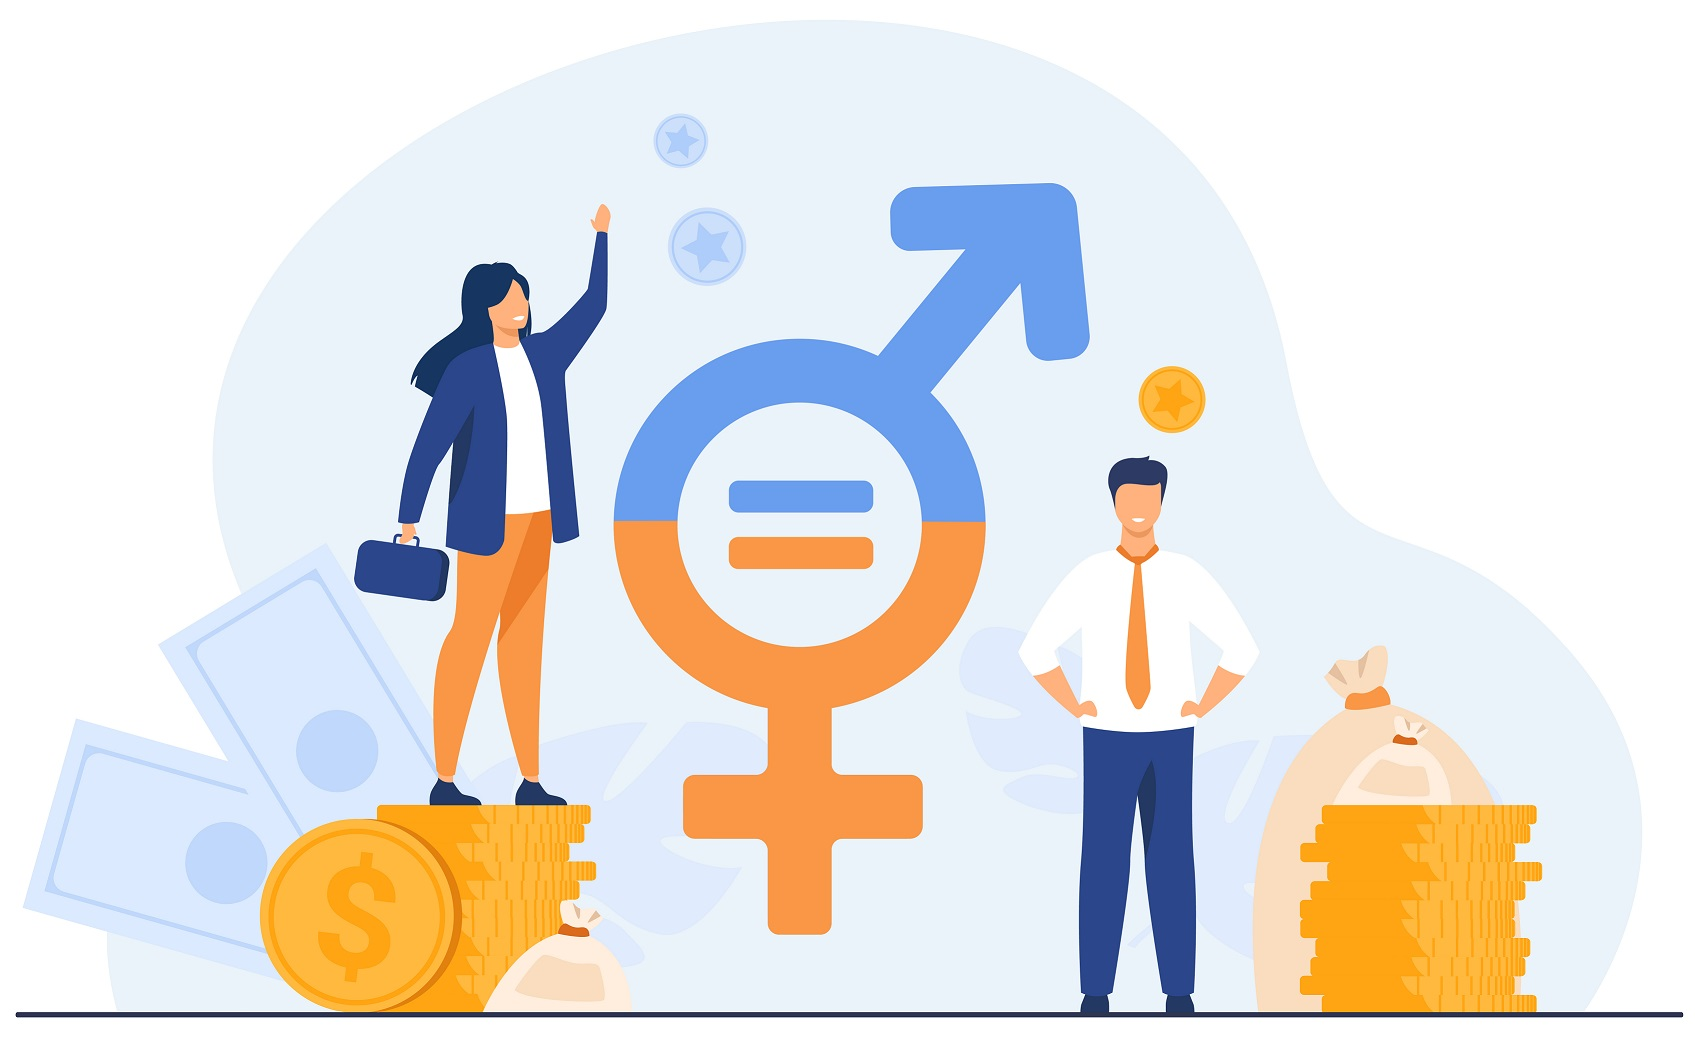
<center>Photo <a href="http://www.freepik.com">Designed by Freepik</a>.</center>

Visualizing the previous result was really shocking. Why is there such a big difference in salaries between men and women? Is it because of the country distribution, age distribution, role title distribution, etc.?

In this section of the notebook, we will be answering a plethora of questions that will focus on breaking down salaries for both genders by various features, such as the ones mentioned previously, in the quest of interpreting the above boxplot.

So, let's put our detective hats on and dive into the data 🕵️‍♀️🕵️‍♂️.

---

**⚠ Important Note:** Students in this dataset have NaN salaries, so their presence in the data won't affect any of the numbers calculated below. In other words, women's higher distribution in the student role title will not affect any of the averages shown below. *For more technical folks, pandas disregards NaN values instead of treating them as zeros*.

---


In [ ]:
def plot_gender_salary_by(by, to_drop=None, sort_by_mean=True, show_bar_plot=True, show_ratio_plot=True, legend_x=0.99):
    # Initializing dfs
    salary_women = pd.pivot_table(df_women, values=['Salary'], columns=[by], aggfunc='mean', fill_value=0).T
    salary_women.columns = salary_women.columns.str.replace('Salary', 'Women')
    salary_men = pd.pivot_table(df_men, values=['Salary'], columns=[by], aggfunc='mean', fill_value=0).T
    salary_men.columns = salary_men.columns.str.replace('Salary', 'Men')
    
    salary_all = pd.pivot_table(df_men_women, values=['Salary'], columns=[by], aggfunc='mean', fill_value=0).T
    salary_all.columns = salary_all.columns.str.replace('Salary', 'All')
    salary_gender = pd.concat([salary_men, salary_women, salary_all], axis=1)
    if sort_by_mean:
        salary_gender.sort_values(['All'], ascending=False, inplace=True)
    all_column = salary_gender['All']
    salary_gender.drop('All', axis=1, inplace=True)
    if to_drop is not None:
        salary_gender.drop(to_drop, axis=0, inplace=True)
    
    # Bar Plot
    if show_bar_plot:
        fig = px.bar(salary_gender, barmode="group")
        fig.update_traces(marker_line_color='rgb(55,55,55)',
                          marker_line_width=1.5, opacity=0.8,
                          hovertemplate=None)
        fig.add_trace(go.Scatter(x=salary_gender.index,y=all_column, line={"color":"Green"}, marker_symbol="square", opacity=0.7, mode='lines+markers', name="Average Salary"))
        fig.update_layout(margin={"r":20, "l":30},
                          plot_bgcolor="#fff",
                          bargap=0.5,
                          hovermode="x",
                          xaxis={"range":[-1,salary_gender.shape[0]]},
                          yaxis={"title": "Yearly Compensation (approximate $USD)", "range":[0, max(salary_gender.Men.max(), salary_gender.Women.max()) * 1.05],
                                 "tickprefix":"$",
                                 "gridcolor": "rgb(235,235,235)", "zeroline":True, "zerolinecolor":"lightgrey"},
                          legend={"yanchor":"top", "y":0.97, "xanchor":"right", "x":legend_x, "title":"",
                                  "bordercolor":"Black", "borderwidth":2, "bgcolor": 'rgba(255,255,255,0.5)'},
                          title=f"<b>Compensation Breakdown by {by} and Gender</b>", title_font_size=20
                         )
        fig.show()
    
    # Ratio Scatter Plot
    if show_ratio_plot:
        salary_gender['ratio'] = salary_gender['Men'] / salary_gender['Women']
        salary_gender.sort_values(['ratio'], ascending=False, inplace=True)
        salary_gender['color'] = salary_gender.apply(lambda row: "Men earn more" if row.ratio > 1 else "Women earn more", axis=1)

        fig = px.scatter(salary_gender, y='ratio', size='ratio', color='color')
        fig.add_shape(type='line',
                      x0=0, y0=1,
                      x1=salary_gender.shape[0] - 1, y1=1,
                      line={"color":'Green', "width":1},
                      xref='x', yref='y'
                     )
        fig.add_annotation(x=0, y=1,
                           text="ratio = 1",
                           showarrow=False,
                           xanchor="left",
                           yanchor="bottom",
                           font={"color":"Green", "size":14}
                          )
        fig.update_layout(margin={"r":20, "l":30, "pad":50},
                          xaxis={"gridcolor": "rgb(235,235,235)"},
                         yaxis={"title":"Compensation Ratio (Men/Women)",
                         "gridcolor": "rgb(235,235,235)", "zeroline":True, "zerolinecolor":"lightgrey"},
                         hovermode="x",
                          plot_bgcolor="#fff",
                         legend={"yanchor":"top", "y":0.97, "xanchor":"right", "x":0.99, "title":"", "bordercolor":"Black", "borderwidth":1, "bgcolor": 'rgba(255,255,255,0.5)'},
                         title=f"<b>Compensation by Gender Ratio Breakdown by {by}</b>", title_font_size=20)
        fig.update_traces(marker_line_color='rgb(75,75,75)',
                          marker_line_width=1.5, opacity=0.9,
                         hovertemplate=None)
        fig.show()

In [ ]:
plot_gender_salary_by("Country", show_ratio_plot=False)

First, let's investigate the difference in the average yearly compensation between men and women by country, as this could be one of the most affecting factors, given that the gender distribution by country is fairly variable.

In the bar chart above, and following the average salary line, respondents from the **USA** and **Switzerland** seem to earn the most with an average of *\$120k* yearly compensation. Respondents from **India** in contrast earn less than *15\%* of this figure, averaging at a *\$17.7K* yearly compensation. At the bottom, we have **Iran** and **Bangladesh** with average yearly compensations of *\$5.5K* and *\$4.5k* respectively.

With the average salary out of the way, it is clear that **in most countries, men earn more than women**. Let's quantify this difference and rank countries based on their difference in salaries between men and women.

In [ ]:
plot_gender_salary_by("Country", show_bar_plot=False)

The above chart plots the compensation ratio between men and women for each country, that is: *Men_Yearly_Compensation / Women_Yearly_Compensation*. For instance, **Nepal** holds the highest ratio by far of *27x*, meaning that men respondents from Nepal earn a staggering **27 times more** than women respondents from Nepal do. **Sri Lanka** and **Ghana** are up next with ratios of *12.9x* and *10.1x* respectively. This ratio drops at *5.4x* for **Colombia** and continue its gradual fall until reaching *2.1x* for **Philippines**, making up for a total of **25 countries where Men earn more than 2 times of what Women earn in the same country**.

The **Netherlands**, **Malaysia**, **Switzerland**, **Viet Nam** and **Australia** are the countries approaching the most the **ratio 1**, meaning that men and women earn relatively the same amount in these countries.

Countries such as **Portugal**, **Taiwan**, **Belarus**, **Greece**, **Iran** and **Nigeria** showed an unpopular trait, that is of a ratio below *0.9x*. Meaning that women respondents from these countries earn more than men respondents from the same countries. **Nigeria** is the country in which women earn the most, when compared to men in the same country, with a ratio of *0.42x*. The latter number can be interpreted as follows: Women earn *1/0.42 = 2.38* times more than Men.

I don't know about you, but things are starting to look kind of fishy for me.

In [ ]:
plot_gender_salary_by("Role Title", show_ratio_plot=False)

Moving on to the yearly compensation broken down by the role title, **Product/Project Managers** seem to earn the most, with an average of *\$61K* yearly compensation! **Data Scientists** and **Data Engineers** are right next with *\$54K* and *\$49K* respectively, moving all the way down to **Data Analysts** scoring an average of */$28.8K* yearly compensation.

Shifting our focus to the difference of salaries between men and women, here it is unanimous! Every single role title seems to favor men when it comes to compensation. Let's further assert the degree of this favoritism in a *compensation ratio plot*.

In [ ]:
plot_gender_salary_by("Role Title", show_bar_plot=False)

As observed above, men earn more than women in every category of role title.

**DBA/Database Engineer** seems to be the most discriminating category with a ratio of *3.7x*. However, further investigation of the data shows that this is mostly due to the fact that men working as Database engineers mostly work in higher income countries (such as the USA), whereas women working as Database engineers mostly work in lower income countries (such as India).

That being said, other role titles have ratios ranging between *1.8x* and *1.2x*, with the exception of **Data Analyst**, **Product/Project Manager** and **Data Engineer** that have ratios very close to 1.

In [ ]:
df_women[df_women["Role Title"] == "DBA/Database Engineer"].Country.value_counts()

In [ ]:
df_men[df_men["Role Title"] == "DBA/Database Engineer"].Country.value_counts()

In [ ]:
plot_gender_salary_by("Education", show_ratio_plot=False, sort_by_mean=False, legend_x=0.25)

When it comes to the Education level, the average salary seems to go up from **High school** to **College/University without degree** up to **Professional degree**, reaching *\$38.1K* at the latter. It then experiences a slight drop for **Bachelor's degree** holders, but jumps right back up for folks sticking longer in universities earning **Master's** and **Doctoral** degrees, scoring an average of *\$47K* and *\$63.5K* yearly compensations respectively!

In [ ]:
plot_gender_salary_by("Education", show_bar_plot=False, sort_by_mean=False)

Here again, men seem to earn more than women in every single category. A downwards trend of the compensation ratio is experienced however when going up in the education levels, nevertheless, this ratio remains as big as *1.35x* even at doctoral levels.

That being said, one data point clearly stands out from the rest, and that's the compensation ratio for **High school** diploma holders, going as far as *23.5x*! Let's take a look at the tables below to further understand the reasons behind this outlier.

In [ ]:
def gender_role_title_table(by, value, subplot_titles=("","")):
    women_category = df_women[df_women[by] == value]['Role Title'].value_counts()
    men_category = df_men[df_men[by] == value]['Role Title'].value_counts()

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "table"}, {"type": "table"}]],
        subplot_titles=subplot_titles)

    headerColor = 'royalblue'
    rowEvenColor = 'lavender'
    rowOddColor = 'white'

    fig.add_trace(go.Table(
                  header=dict(
                    values=["<b>Role Title</b>", "<b>Respondents Count</b>"],
                    line_color='darkslategray',
                    fill_color=headerColor,
                    align='center',
                    font=dict(color='white', size=12)
                  ),
                  cells=dict(
                    values=np.array([list(women_category.index) + ["<b>Total</b>"], ["<b>" + str(x) + "</b>" for x in women_category.values] + ["<b>" + str(women_category.values.sum()) + "</b>"]]),
                    line_color='darkslategray',
                    # 2-D list of colors for alternating rows
                    fill_color = [[rowOddColor,rowEvenColor]*10],
                    align = 'center',
                    font = dict(color = 'darkslategray', size = 11)
                    )),
                 row=1, col=1)

    fig.add_trace(go.Table(
                  header=dict(
                    values=["<b>Role Title</b>", "<b>Respondents Count</b>"],
                    line_color='darkslategray',
                    fill_color=headerColor,
                    align='center',
                    font=dict(color='white', size=12)
                  ),
                  cells=dict(
                    values=np.array([list(men_category.index) + ["<b>Total</b>"], ["<b>" + str(x) + "</b>" for x in men_category.values] + ["<b>" + str(men_category.values.sum()) + "</b>"]]),
                    line_color='darkslategray',
                    # 2-D list of colors for alternating rows
                    fill_color = [[rowOddColor,rowEvenColor]*10],
                    align = 'center',
                    font = dict(color = 'darkslategray', size = 11)
                    )),
                 row=1, col=2)

    fig.update_layout(margin={"b":0, "t":40, "r":50, "l":50})

    fig.show()

In [ ]:
def role_title_table(by, value, subplot_titles=("",)):
    men_women_category = df_men_women[df_men_women[by] == value]['Role Title'].value_counts()

    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{"type": "table"}]],
        subplot_titles=subplot_titles)

    headerColor = 'royalblue'
    rowEvenColor = 'lavender'
    rowOddColor = 'white'

    fig.add_trace(go.Table(
                  header=dict(
                    values=["<b>Role Title</b>", "<b>Respondents Count</b>"],
                    line_color='darkslategray',
                    fill_color=headerColor,
                    align='center',
                    font=dict(color='white', size=12)
                  ),
                  cells=dict(
                    values=np.array([list(men_women_category.index), ["<b>" + str(x) + "</b>" for x in men_women_category.values]]),
                    line_color='darkslategray',
                    # 2-D list of colors for alternating rows
                    fill_color = [[rowOddColor,rowEvenColor]*10],
                    align = 'center',
                    font = dict(color = 'darkslategray', size = 11)
                    )),
                 row=1, col=1)

    fig.update_layout(margin={"b":0, "t":40, "r":150, "l":150})

    fig.show()

In [ ]:
gender_role_title_table("Education", "High school", subplot_titles=(f"<b>Women with a<br>High School Diploma</b>", f"<b>Men with a<br>High School Diploma</b>"))

On the left we can see a table of all women respondents holding, or planning to hold a High school diploma within 2 years, and on the right we have the same table for men. The first thing to stand out is the much bigger number of men in this category. Only **13 women** participating in this survey chose High school as their education level, whereas **200 men** choose this option in the survey!

Further analyzing the numbers in the men's table, 2 main reasons arise:
1. **Men are more likely to get into this field at younger ages**: This can be clearly observed with the 57 participants describing themselves as *students* while in high school, meaning that they are still undergoing studies in high school and are interested in data science at a young age. This can be attributed to a large number of factors, from which: *parents tend to encourage young men to undergo such career paths more than they do with young women*, and *young boys tend to play more video games on their laptops, grating them more exposure to the internet as a whole, which in turn facilitates their transition into such a field, should there be such a transition*.
2. **Men are more likely to stop their education early on and start working as soon as possible**: This is distinctively showcased in the table above with the 143 *non-student* respondents that chose high school as their highest education level achieved. The majority of these respondents work in various sectors of this field, going from the most common role title of **Software Engineer** with 28 respondents, all the way to the **Product/Project Manager** role title, which conventionally takes years of experience before reaching!

In [ ]:
plot_gender_salary_by("Company Size", sort_by_mean=False, legend_x=0.25)

One other interesting relationship to study is the effect of the company size on the average salaries of its employees. Looking at the bar chart above, there is a clear positive correlation between the size of a company and the average salaries of its employees! Actually, the average yearly remuneration goes up from *\$29.1K* for companies with 0-49 employees, all the way to *\$61.5K* for companies with 10,000+ employees.

Shifting our focus to the compensation ratio plot below it, we can observe a higher rate of salary discrimination by gender in small sized companies (with 0-49 employees) with a compensation ratio of *1.8x*. All other company sizes seem to have an average compensation ratio of *1.28x*.

In [ ]:
plot_gender_salary_by("Years of Programming", sort_by_mean=False, show_ratio_plot=False, legend_x=0.25)

In this graph we can see the progression of yearly compensations with respect to the years of programming that a given respondent has. Respondents that never wrote code have an average of *\$24.4K* yearly compensation. With some programming experience however, despite it taking a couple of years to kick off and show benefits, respondents tend to ear more, the more programming experience they have up their sleeves. For instance, respondents having 3-5 years of programming experience showed an average of *\$34K* yearly compensation, whereas respondents that have been programming for more than 20 years, averaged a peak of *\$88.1K* yearly compensation.
 
Once again, it seems like men tend to earn more than women in every single experience category, albeit having categories with more aggressive ratios.

---

Let's take a small detour and answer an interesting question before we go further: *What do respondents with no programming experience whatsoever work as?*

In [ ]:
role_title_table("Years of Programming", "I have never written code", subplot_titles=(f"<b>Respondents Who Have Never Written Code</b>",))

Most respondents that have no programming experience are still **students** (*279*). After which there are *200* respondents that work **other jobs** and *158* are **currently not employed**. When it comes to data-related roles, **Business Analysts** are the most common respondents with *93* respondents having no prior coding experience, followed by **Data Analysts** with *89* respondents. These are roles that can be achieved without any kind of programming by using *Business Intelligence* tools such as *Tableau* and *Microsoft Power BI* to take care of all the data-related tasks!

In [ ]:
plot_gender_salary_by("Years of Machine Learning", sort_by_mean=False, show_ratio_plot=False, legend_x=0.25)

Now, plotting the relationship between years of machine learning experience and salary, we can observe a very similar pattern to the one observed when plotting the relationship between years of programming experience and salary.

Respondents who don't use machine learning methods have an average yearly compensation of *\$38K*. As with the programming experience, it takes a couple of years of machine learning experience for it to kick off and start showing considerable gains in salaries, reaching an astonishing *\$125K* yearly remuneration for respondents with more than 20 years of experience using machine learning methods!

It is also interesting to point out that a data scientist with 5-10 years of experience in machine learning earns more (*\$93.7K*) than a data scientist with 20+ years of experience in programming as a whole (*\$88.1K*). Thus, one can conclude that **machine learning experience is more valuable than programming experience**.

Oh and yeah, men earn more than women in all categories, except one tiny exception.

---

Let's take one more detour to answer a similar question to the one we asked previously: *What do respondents who don't use machine learning methods work as?*

In [ ]:
role_title_table("Years of Machine Learning", "I do not use machine learning methods",
                 subplot_titles=(f"<b>Respondents Who Don't Use Machine Learning Methods</b>", ))

Besides students and other occupations, respondents who don't use machine learning methods work as **Software Engineers** most of the times, followed by **Data Analysts** and **Business Analysts**.

*Apparently there are 22 Machine Learning Engineers that don't use machine learning methods... That's rather interesting! #noiseiseverywhere.*

In [ ]:
plot_gender_salary_by("Data Science Employees", sort_by_mean=False, show_ratio_plot=False, legend_x=0.25)

From the graph above, we can clearly notice that the more data science employees a company has, the higher are the salaries of its employees! This consequently means that a company's revenue can be somewhat estimated by its number of data science employees.

It is also interesting to distinguish that the most considerable monetary gains for a given company occur when going from **0** to **1-2** data science employees, and from **15-19** to **20+** data science employees!

In [ ]:
def plot_gender_salary_by(by, to_drop=None, sort_by_mean=True, legend_x=0.99):
    # Initializing dfs
    salary_women = pd.pivot_table(df_women, values=['Salary'], columns=[by], aggfunc='mean', fill_value=0).T
    salary_women.columns = salary_women.columns.str.replace('Salary', 'Women')
    salary_men = pd.pivot_table(df_men, values=['Salary'], columns=[by], aggfunc='mean', fill_value=0).T
    salary_men.columns = salary_men.columns.str.replace('Salary', 'Men')
    
    # Bar Plot
    salary_all = pd.pivot_table(df_men_women, values=['Salary'], columns=[by], aggfunc='mean', fill_value=0).T
    salary_all.columns = salary_all.columns.str.replace('Salary', 'All')
    salary_gender = pd.concat([salary_men, salary_women, salary_all], axis=1)
    if sort_by_mean:
        salary_gender.sort_values(['All'], ascending=False, inplace=True)
    all_column = salary_gender['All']
    salary_gender.drop('All', axis=1, inplace=True)
    if to_drop is not None:
        salary_gender.drop(to_drop, axis=0, inplace=True)
    fig = px.bar(salary_gender, barmode="group")
    fig.update_traces(marker_line_color='rgb(55,55,55)',
                      marker_line_width=1.5, opacity=0.8,
                      hovertemplate=None)
    fig.add_trace(go.Scatter(x=salary_gender.index,y=all_column, line={"color":"Green"}, marker_symbol="square", opacity=0.7, mode='lines+markers', name="Average Salary"))
    fig.update_layout(margin={"r":20, "l":30},
                      plot_bgcolor="#fff",
                      bargap=0.5,
                      hovermode="x",
                      xaxis={"range":[-1,salary_gender.shape[0]],
                            "tickmode":"array", "tickvals": [0,1,2,3,4,5],
                             "ticktext":['We have well established ML methods<br>(i.e., models in production for more than 2 years)',
                                         'We recently started using ML methods<br>(i.e., models in production for less than 2 years)',
                                         'We use ML methods for generating insights<br>(but do not put working models into production)',
                                         'We are exploring ML methods (and may<br>one day put a model into production)',
                                         'I do not know',
                                         'No (we do not use ML methods)',
                                         ]
                            },
                      yaxis={"title": "Yearly Compensation (approximate $USD)", "range":[0, max(salary_gender.Men.max(), salary_gender.Women.max()) * 1.05],
                             "tickprefix":"$",
                            "gridcolor": "rgb(235,235,235)", "zeroline":True, "zerolinecolor":"lightgrey"},
                      legend={"yanchor":"top", "y":0.97, "xanchor":"right", "x":legend_x, "title":"", "bordercolor":"Black", "borderwidth":2, "bgcolor": 'rgba(255,255,255,0.5)'},
                      title=f"<b>Compensation Breakdown by {by}<br>and Gender</b>", title_font_size=20)
    fig.show()


In [ ]:
plot_gender_salary_by("Machine Learning Incorporation")

Similarly to the previous graph, here we can spot a positive correlation between the incorporation of machine learning methods in companies, and their employees earning higher salaries!

The most benefits by far are observed for companies that go from their first machine learning deployments (less than 2 years of exposure in this market) to deploying machine learning models in production for more than 2 years!

---
Hold on for a second 🤚.


Did you notice something?

It's almost as if we got acquainted with the idea that men earn more than women throughout this notebook, that it doesn't even shock us anymore. Going from a detailed breakdown of the gender compensation ratios by country in the first graphs of this section, to not even mentioning it in the last 2 graphs, it felt kind of "normal" or "expected" at the latter point.

No matter how we turn this around, **men earn more than women**. Either be it by country, by education level, by years of programming or machine learning experience, by role title, by company size, **you name it!** Every single breakdown of salaries by gender led to the same conclusion: **men earn more than women**. It was only with big numbers of sub-categories, such as in countries or years of machine learning experience, that under certain conditions, *sometimes*, women would earn more than men. It almost feels like willingly searching for an exception to find one.

The boxplot which we've ended the second section of this notebook with, was indeed a *valid one*. Every kind of analysis we undertook throughout this section showed traces of this boxplot, so let's visualize it one more time:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=df_men[df_men['Role Title'] != "Student"].Salary, name="Men", boxmean=True))
fig.add_trace(go.Box(y=df_women[df_women['Role Title'] != "Student"].Salary, name="Women", boxmean=True))
fig.update_layout(title="<b>Yearly Compensation: Men VS Women</b>",
                  title_font_size=20,
                  yaxis={"title":"Yearly Compensation (approximate $USD)",
                         "range":[0,150000], "tickprefix":"$",
                         "gridcolor": "rgb(235,235,235)", "zeroline":True, "zerolinecolor":"lightgrey"},
                  xaxis={"title":"Gender"},
                  showlegend=False,
                  autosize=False, width=600, height=650,
                  plot_bgcolor="#fff",
                  
                 )

# 100K line
fig.add_shape(type='line',
              x0=-0.5, y0=100000,
              x1=1.5, y1=100000,
              line={"color":'grey', "width":2, "dash":"dash"},
              xref='x', yref='y',
              layer="above"
             )
# Grey circle for men
fig.add_shape(type='circle',
              x0=-0.031, y0=97800,
              x1=0.031, y1=102200,
              line_color="grey",
              fillcolor="darkgrey",
              opacity=0.7,
              name="H"
             )
fig.add_trace(
    go.Scatter(
        x=["Men"],
        y=[100000], 
        fill="toself",
        mode='markers',
        name='',
        marker={"color":"grey"},
        hovertemplate='<i>$100K salary for men<br>is a normal data point</i>',
        hoverlabel={"bgcolor":"#fff"},
        opacity=0
    )
)
# Grey circle for women
fig.add_shape(type='circle',
              x0=1-0.031, y0=97800,
              x1=1.031, y1=102200,
              line_color="grey",
              fillcolor="darkgrey",
              opacity=0.7
             )
fig.add_trace(
    go.Scatter(
        x=["Women"],
        y=[100000], 
        fill="toself",
        mode='markers',
        name='',
        marker={"color":"grey"},
        hovertemplate='<i>$100K salary for women<br>is an <b>outlier</b></i>',
        hoverlabel={"bgcolor":"#fff"},
        opacity=0
    )
)
# Men mean line
fig.add_shape(type='line',
              x0=-0.24, y0=46125,
              x1=0.74, y1=46125,
              line={"color":'#6f7afa', "width":2, "dash":"dot"},
              xref='x', yref='y'
             )
fig.add_annotation(x=0.5, y=46125,
                   text="46,125$",
                   showarrow=False,
                   xanchor="center",
                   yanchor="bottom",
                   font={"color":"#6f7afa", "size":14}
                  )
# Women mean line
fig.add_shape(type='line',
              x0=0.26, y0=32960,
              x1=1.24, y1=32960,
              line={"color":'#ee634d', "width":2, "dash":"dot"},
              xref='x', yref='y'
             )
fig.add_annotation(x=0.5, y=32960,
                   text="32,960$",
                   showarrow=False,
                   xanchor="center",
                   yanchor="top",
                   font={"color":"#ee634d", "size":14}
                  )
# 40% Arrow
fig.add_annotation(x= 0.38, y= 46125 - 2000,
                   ax= 0.38, ay= 32960 + 2000,
                   xref="x", yref="y",
                   text="",
                   showarrow=True,
                   axref = "x", ayref='y',
                   arrowhead = 1, arrowwidth=2.5,
                   arrowcolor='rgb(75,75,75)'
                  )
fig.add_annotation(x=0.51, y=(32960 + 46125) // 2,
                   text="<b>40%</b>",
                   showarrow=False,
                   xanchor="center",
                   yanchor="middle",
                   font={"color":"rgb(75,75,75)", "size":16}
                  )

fig.show()

This boxplot was indeed correct:
* Whereas 50% of men have a yearly salary that is at most *\$22.5K*, this number **drops** to *\$8.8K* for women.
* Whereas a *\$100K* yearly salary is "normal", per se, for men (being a mere data point in the 4th, or top 25%, quantile for men), this same salary is considered an **outlier** for women.
* Whereas the top 25% quantile of men earn anywhere between *\$65K* and *\$137.5K*, this range **drops** to become between *\$44.5K* and *\$95K* for the top 25% quantile of women.
* Whereas in average men earn *\$46.1K*, women in average earn *\$33K*, making for an overall compensation ratio of **1.4x**.

The reasons for this saddening outcome are outside of the scope of this notebook. As for the solutions, there are a ton of them, and all of us can help in removing such an unhealthy disparity.
1. **Transparency over pay**: Being open about how a given company calculates salaries based on roles and qualifications (only) is a crucial factor, not just in reducing potential gender pay gaps, but rather as a general means to give more power back to the employees and ensure a fair and healthy workplace for everyone. We as a community should normalize making promotions and pay rises transparent. One additional factor here is the generally higher rate of agreeableness in women. This leads to having men being more comfortable in salaries negotiations, which in turns lead to higher salaries for men. 
2. **Compassion towards maternity leave**: This really goes in both directions. First off, women suffer a lot from maternity leaves, both health and career wise. Quoting [zenefits](https://www.zenefits.com/workest/how-maternity-leave-works-the-employers-guide/#:~:text=While%2070%25%20of%20women%20report,the%20birth%20of%20their%20child.), *\"While 70% of women report taking some time off after a birth, 16% report they take only 1 to 4 weeks; about half take at least 5 weeks of leave and 25% take nine weeks or longer. The remaining one-third of mothers don’t take any time off, returning to work almost immediately after the birth of their child.\"*. Of course, should they have the option, women would take longer maternity leaves, but given the excessive stress of losing their jobs and the non-existent compassion in many companies around the world, they end up taking a huge hit on their health and career paths. Secondly, men should be encouraged to take paternity leaves, as they are fathers as women are mothers. This would balance the scale when it comes to parental leave for all employees, and would relieve a lot of stress from women taking care of their children by themselves.
3. **Encourage remote working**: While Covid-19 has already contributed greatly towards moving in this direction, more efforts should be put into it. Benefiting from flexible hours would tremendously benefit women in their quest of balancing both household/childcare responsibilities and a healthy career/income. *If we, as data scientists don't encourage such a culture first, who will do it?*

---

*And if you're still somewhat unconvinced (like I was), thinking that only working with one variable at a time is not sufficient and that a multivariate study would lead to probably different results (for example, this means that one should study the difference between men and women when they are from the same country, have the same age and work the same job for example), well... you're wrong. You see, this kind of study would prove beneficial if men earned more than women in **most** of the cases, but not **all of them**. However, and as we've seen with countless visualizations, men are earning more than women in every single mentionable regard! The number of conditions in which women earn more than men can be counted on one hand, and one might even consider them **exceptions**. In all cases, and for you who won't be convinced unless you see hard numbers (kudos!), please feel free to expand the code block right underneath this one to check out a simple multivariate study I did, taking into account the country, the age range, the role title and the years of programming experience all at the same time, and yet the resulting gender compensation ratio came out at **1.33x**.*

In [ ]:
count_women = pd.pivot_table(df_women, values=['Salary'], columns=["Country", "Role Title", "Age Range", "Years of Programming"], aggfunc='count', fill_value=0).T
count_men = pd.pivot_table(df_men, values=['Salary'], columns=["Country", "Role Title", "Age Range", "Years of Programming"], aggfunc='count', fill_value=0).T

count_women.index = count_women.index.to_flat_index()
count_women.index = [" ".join([str(y) for y in x]) for x in count_women.index]
count_men.index = count_men.index.to_flat_index()
count_men.index = [" ".join([str(y) for y in x]) for x in count_men.index]

count_women.columns = count_women.columns.str.replace('Salary', 'num_women')
count_men.columns = count_men.columns.str.replace('Salary', 'num_men')

count_gender = pd.concat([count_women, count_men], axis=1)

women_salary = pd.pivot_table(df_women, values=['Salary'], columns=["Country", "Role Title", "Age Range", "Years of Programming"], aggfunc='mean', fill_value=np.nan).T
men_salary = pd.pivot_table(df_men, values=['Salary'], columns=["Country", "Role Title", "Age Range", "Years of Programming"], aggfunc='mean', fill_value=np.nan).T

women_salary.index = women_salary.index.to_flat_index()
women_salary.index = [" ".join([str(y) for y in x]) for x in women_salary.index]
men_salary.index = men_salary.index.to_flat_index()
men_salary.index = [" ".join([str(y) for y in x]) for x in men_salary.index]

women_salary.columns = women_salary.columns.str.replace('Salary', 'Women Salary')
men_salary.columns = men_salary.columns.str.replace('Salary', 'Men Salary')

gender_salary = pd.concat([men_salary, women_salary], axis=1)

gender_salary_count = pd.concat([gender_salary, count_gender], axis=1)

print("Initial Shape:", gender_salary_count.shape[0])

gender_salary_count.dropna(inplace=True)

print("Shape after removal of NaN:", gender_salary_count.shape[0])

gender_salary_count = gender_salary_count[(gender_salary_count.num_men > 1) & (gender_salary_count.num_women > 1)]

print("Shape after only keeping rows with atleast 2 occurences of both genders:", gender_salary_count.shape[0])

print(gender_salary_count['Men Salary'].mean() / gender_salary_count['Women Salary'].mean())

gender_salary_count.head()

# Bonus: What Degree do I Need to Work as ... ? <a class="anchor" id="head-4"></a>

Thought we were done here!? Not yet! My enthusiasm for exploring data was still kicking hours before the submission deadline, so I decided to answer a fun question that most of us either asked, are currently asking, or will definitely ask sometime in the future, and that is: What degree do I need to work as a data scientist? What degree do I need to work as a machine learning engineer? Do I need a doctoral degree to work as a research scientist?

Let's find out 😊

In [ ]:
degree_vs_role = pd.pivot_table(df.loc[:, ['Education', 'Role Title']],
                                index='Education', columns='Role Title', aggfunc='size', fill_value=0)
degree_vs_role.drop([
    'Student',
    'Currently not employed',
    'Other'
], axis=1, inplace=True)

In [ ]:
fig = px.line(degree_vs_role,
             color_discrete_sequence=px.colors.qualitative.Set3,
             title="<b>Role Title Popularity for each Education Level</b>"
            )

fig.update_traces(hovertemplate = "<b>%{fullData.name}</b><br>Education: %{x}<br>Respondents: %{y}<extra></extra>")
fig.update_layout(title_font_size=20,
                  yaxis={"title": "Number of Respondents", "gridcolor": "rgb(235,235,235)",
                         "zeroline":True, "zerolinecolor":"lightgrey"},
                  xaxis={"title":"Highest Level of Formal Education"},
                  plot_bgcolor="#fff"
                 )

fig.show()

Here we can see the most popular role title for each education level!

**Software Engineer** seems to be the most popular role title for holders of *High school*, *No degree*, *Professional degree* and *Bachelor's degree*.

**Data Scientist** is a role that gains lots of popularity going from a *Professional degree* to a *Bachelor's degree*, and then gains extreme popularity and peaks out at the *Master's degree* level!

As Expected, **Research Scientist** is the most popular role title for *PhD holders*.

In [ ]:
degree_vs_role_percentage = degree_vs_role.iloc[:, :].apply(lambda x: x / x.sum())

In [ ]:
fig = px.line(degree_vs_role_percentage,
             color_discrete_sequence=px.colors.qualitative.Set3,
             title="<b>Role Title Distribution with Respect to Education</b>"
            )

fig.update_traces(hovertemplate = "<b>%{fullData.name}</b><br>Education: %{x}<br>% Respondents: %{y}<extra></extra>")
fig.update_layout(title_font_size=20,
                  yaxis={"title": "% of Respondents Having this Role Title", "gridcolor": "rgb(235,235,235)",
                         "zeroline":True, "zerolinecolor":"lightgrey",
                         "tickformat":".1%"},
                  xaxis={"title":"Highest Level of Formal Education"},
                  plot_bgcolor="#fff"
                 )

fig.show()

Now, moving to a more interesting graph, above we can see the distribution of each role title among the available education levels.

Let's further enhance our visualization by plotting the cumulative sum of this graph next!

In [ ]:
def color(color, text):
    s = '$\color{' + str(color) + '}{' + str(text) + '}$'
    return s

fig = px.line(degree_vs_role_percentage.cumsum(),
             color_discrete_sequence=px.colors.qualitative.Set3,
             title="<b>Role Title Distribution with Respect to Education</b>"
            )

fig.update_traces(hovertemplate = "<b>%{fullData.name}</b><br>Education: %{x}<br>% Respondents: %{y}<extra></extra>")
fig.add_shape(type='line',
              x0=4, y0=0,
              x1=4, y1=1,
              line={"color":'Green', "width":3, "dash":"dot"},
              xref='x', yref='y',
              layer="below"
             )
fig.update_layout(title_font_size=20,
                  yaxis={"title": "% of Respondents Having this Role Title", "gridcolor": "rgb(235,235,235)",
                         "zeroline":True, "zerolinecolor":"lightgrey",
                         "tickformat":".1%"},
                  xaxis={"title":"Highest Level of Formal Education", "showgrid": False},
                  plot_bgcolor="#fff"
                 )

fig.show()

Here we can see a much more interpretable plot!

**Master's degree** seem to reap the most benefit for most role titles. In fact, *95%* of **Business Analysts** and **Data Analysts** hold a Master's or a smaller degree. This number remain as high as *90.5%* for **Data Engineers** and *86%* and *83%* respectively for both **Machine Learning Engineers** and **Data Scientists**.

A **Doctoral degree** however seem to only benefit people looking to work either as *Research scientists* or *statisticians*. Looking at the graph above, it looks like less than half of **Research Scientists** hold a master's or a lower degree, with this number falling down to *11.5%* when it comes to respondents with a bachelor's or lower degree.

---

That's it for this notebook! I really hope that you've enjoyed the ride and it's been worth your precious time!

Don't forget to support me with an up vote if you've learned something new going through this work!

Happy data exploring everyone 🎉